In [1]:
import numpy as np
import os
import pandas as pd
from pandas import ExcelWriter
import matplotlib.pyplot as plt
import openpyxl
import matplotlib as mpl
import scipy as sp
from scipy import stats
from scipy import signal
from scipy import fft
from scipy import io
from scipy import interpolate
from scipy import optimize
from scipy import linalg
from scipy import integrate
from scipy.fft import dct

mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = [
    r'\usepackage{textcomp}',
    r'\usepackage{wasysym}']
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.size'] = 22
mpl.rcParams['font.family'] = 'STIXGeneral'

saveFigs = False



In [2]:
from GetCoreData_fct import GetCoreData

import sys 
import os
sys.path.append('../')

from BackDiffuse_LT import BackDiffuse


from Interpolation_Class import Interpolation

from HL_AnalyticThea_class import HL_Thea
from DiffusionProfiles_calculations import DiffusionLength

from sigmaSolver import sigma_Solver



In [3]:
from transforms import transforms
from Decon import SpectralDecon

In [4]:
sites = ['SiteA', 'SiteB', 'SiteD', 'SiteE', 'SiteG', 'Crete']
N_InInts = [33, 33, 33, 33, 33, 33]
Nt_InInts = [33, 33, 33, 33, 33, 33]

j = 0

site = sites[j]
N_InInt = N_InInts[j]

N_InInt_test = 35

CoresSpecs = pd.read_csv('/home/thea/Documents/KUFysik/MesterTesen/Data/CoreSpecs.txt', ',')

coreNames = CoresSpecs['CoreName']


core_idx = coreNames[CoresSpecs['CoreName'] == site].index[0]
CoreSpecs = CoresSpecs.iloc[core_idx]
dTamb = CoreSpecs['dTamb']
dLaki = CoreSpecs['dLaki']
accum0 = CoreSpecs['Accum0']
accumIE = CoreSpecs['Accum1']
Temp0 = CoreSpecs['T0']

DataAll = GetCoreData(site, 'Alphabet')

data_d18O = DataAll[0]; data_d18O_LT = DataAll[1]
data_ECM = DataAll[2]; data_ECM_LT = DataAll[3]
data_dens = DataAll[4]; data_dens_LT = DataAll[5]
data_diff = DataAll[6]; data_diff_LT = DataAll[7]


depth_LT = data_d18O_LT['depth']
d18O_LT = data_d18O_LT['d18O']
dataAll = pd.DataFrame({'depth':depth_LT,'d18O':d18O_LT}, index=None)

In [5]:
inst32 = BackDiffuse(site, data_d18O_LT, CoresSpecs, dTamb, dLaki, N_InInt, diffLenData=data_diff_LT[['Depth','sigma_o18']], densData=data_dens_LT)

depthOpt32, dataOpt32, diffLen32, peaks32, arr_DiffLens32, arr_Npeaks32, arr_depth32, arr_data32 = inst32.backDiffused(theoDiffLen=True,print_Npeaks=False, diffLenStart_In=0.005, diffLenEnd_In=0.15, interpAfterDecon=True)

Sigma fit: 7.32
Min sigma analyt: 7.69
Starting sigma: 5.32 [cm]
Final sigma: 6.20 [cm]
Final # of peaks: 33
Delta: 0.038
Delta new: 0.019


In [6]:
#inst_test = BackDiffuse(site, data_d18O_LT, CoresSpecs, dTamb, dLaki, N_InInt_test, diffLenData=data_diff_LT[['Depth','sigma_o18']], densData=data_dens_LT)

#depthOpt_test, dataOpt_test, diffLen_test, peaks_test, arr_DiffLens_test, arr_Npeaks_test, arr_depth_test, arr_data_test = inst_test.backDiffused(theoDiffLen=True,print_Npeaks=False, diffLenStart_In=0.005, diffLenEnd_In=0.15, interpAfterDecon=True)

In [7]:
from DiffusionProfiles_calculations import sampling_sigma
sampleSize_ave = np.mean(np.diff(depth_LT))
print(f'Average sampling size in interval: {sampleSize_ave:.3f}\n')
sigma_sample = sampling_sigma(sampleSize_ave)
sigma32_firn = np.sqrt(diffLen32**2 - sigma_sample**2)
#sigma_test_firn = np.sqrt(diffLen_test**2 - sigma_sample**2)

print(f'Total diffusion length estimate: \t{diffLen32*100:.2f} [cm]')
print(f'Sampling diffusion length estimate: \t{sigma_sample*100:.2f} [cm]')
print(f'Firn diffusion length estimate (32): \t{sigma32_firn*100:.2f} [cm]')
#print(f'Firn diffusion length estimate (test): \t{sigma_test_firn*100:.2f} [cm]')


Average sampling size in interval: 0.039

Total diffusion length estimate: 	6.20 [cm]
Sampling diffusion length estimate: 	1.19 [cm]
Firn diffusion length estimate (32): 	6.08 [cm]


In [8]:
#idx32 = np.where(np.asarray(arr_Npeaks) == N_InInt)[0]
#idx32Cut = idx32[:-1]

#diffLens32_tot = np.asarray(arr_DiffLens)[idx32Cut]
#diffLens32_firn = np.sqrt(diffLens32_tot**2 - sigma_sample**2)

In [9]:
troughs = sp.signal.find_peaks(-dataOpt32)[0]
troughs

array([  9,  26,  42,  57,  76,  88, 103, 127, 142, 154, 169, 186, 206,
       218, 227, 246, 265, 271, 282, 296, 315, 334, 349, 362, 381, 394,
       410, 427, 447, 461, 482, 500, 513])

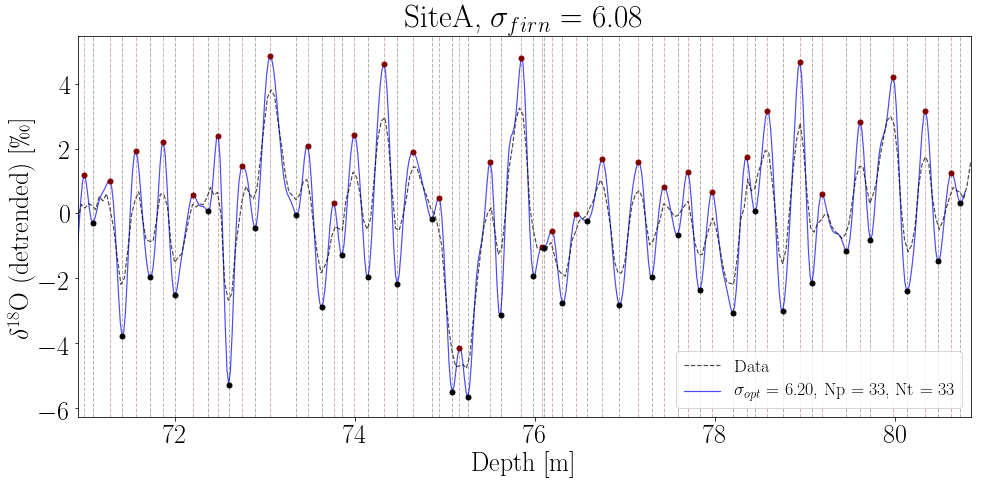

In [11]:
mpl.rcParams['font.size'] = 26

fig, ax = plt.subplots(figsize=(16,7))

plt.plot(np.asarray(depth_LT), np.asarray(d18O_LT)-np.mean(np.asarray(d18O_LT)), lw=1.2, label='Data', ls='--', color='k', alpha=0.7)
plt.plot(depthOpt32, dataOpt32, label='$\sigma_{opt}$ = ' + f'{diffLen32*100:.2f}, Np = {len(peaks32)}, Nt = {len(troughs)}',zorder=-1, color='b', alpha=.7, lw=1.2)
#plt.plot(depthOpt_test, dataOpt_test, label='$\sigma_{opt}$ = ' + f'{diffLen_test*100:.2f}, N = {len(peaks_test)}',zorder=-1, color='b', alpha=.7, lw=1.2)

plt.legend(fontsize=18)
ax.set(xlabel='Depth [m]', ylabel='$\delta^{18}$O (detrended) [\permil]', title=site+', $\sigma_{firn}$ = ' + f'{sigma32_firn*100:.2f}',xlim=(min(depth_LT),max(depth_LT)))
plt.scatter(depthOpt32[peaks32],dataOpt32[peaks32], color='maroon',zorder=1, s=25)
plt.scatter(depthOpt32[troughs],dataOpt32[troughs], color='k',zorder=1, s=25)
#plt.scatter(depthOpt_test[peaks_test],dataOpt_test[peaks_test], color='b',zorder=1, s=25)

for i in range(len(peaks32)):
    ax.axvline(depthOpt32[peaks32[i]],lw=1,color='maroon',ls='--', alpha=0.3)

for i in range(len(troughs)):
    ax.axvline(depthOpt32[troughs[i]],lw=1,color='k',ls='--', alpha=0.3)
#for i in range(len(peaks_test)):
#    ax.axvline(depthOpt_test[peaks_test[i]],lw=1,color='g',ls='--')

fig.savefig('../WrittenWork/Figures/'+site+'_TheoDiffLens33_issue.png', bbox_inches='tight')


In [149]:
T = 12
y1 = 1783
m1 = 10

y2 = 1816
m2 = 7



In [156]:
d1 = y1*12 + m1 - y1*12
d2 = y2*12 + m2 - y1*12

t = np.linspace(d1,d2,int(d2-d1)*100+1)
y = np.sin(2*np.pi*(t+np.pi)/12)
t = t/12 - 1

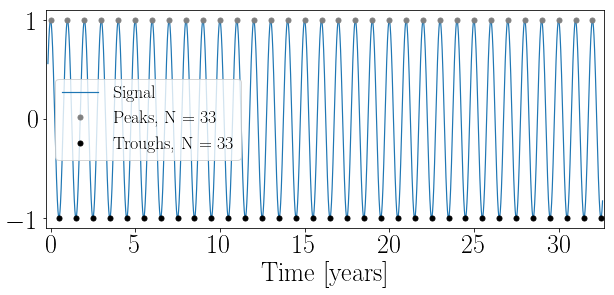

In [158]:
from scipy import signal


peaks = sp.signal.find_peaks(y)[0]
troughs = sp.signal.find_peaks(-y)[0]

fig,ax = plt.subplots(figsize=(10,4))
plt.plot(t,y, label='Signal', lw=1.2)
plt.plot(t[peaks],y[peaks],'.',ms=10,color='gray', label=f'Peaks, N = {len(peaks)}')
plt.plot(t[troughs],y[troughs],'.',ms=10, color='k', label=f'Troughs, N = {len(troughs)}')
ax.set(xlim=(min(t)-0.1,max(t)+0.1), xlabel='Time [years]')
ax.legend(fontsize=18);

fig.savefig('../WrittenWork/Figures/LakiToTambora_EstTime.png', bbox_inches='tight')


In [56]:
len(y[peaks])

33